In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [3]:
# Based on https://link.springer.com/chapter/10.1007/978-3-642-40846-5_16 

# Calculate h(y, Yi)
def h(y, Yi):
    return 1 if y in Yi else 0

# Calculate IRperLabel for each label y
def calculate_IRperLabel(all_labels, df):
    IR = {}
    # Split tags into lists of labels
    df['label_list'] = df['tags'].apply(lambda x: x.split())
    for y in all_labels:
        label_counts = [sum(h(y, Yi) for Yi in df['label_list'])]
        majority_label_count = sum(label_counts)
        
        # Get the number of labels in the dataset
        IR[y] = majority_label_count / len(df) if len(df) > 0 else 0

    return IR

# Calculate MeanIR (average imbalance ratio)
def calculate_MeanIR(IR):
    return np.mean(list(IR.values()))

# Calculate CVIR (coefficient of variation of imbalance ratio)
def calculate_CVIR(IR, MeanIR):
    mean_squared_diff = np.mean([(val - MeanIR)**2 for val in IR.values()])
    return np.sqrt(mean_squared_diff) / MeanIR if MeanIR != 0 else 0

def plot_spread(data):
    # Flatten the list of labels
    all_tags = data['tags'].apply(lambda x: x.split() if isinstance(x, str) else x)
    flattened_tags = [tag for sublist in all_tags for tag in sublist]

    # Convert to a DataFrame for easy handling
    tag_df = pd.DataFrame(flattened_tags, columns=['tag'])

    # Sort tags alphabetically
    sorted_tag_counts = tag_df['tag'].value_counts().sort_index()  # Sort alphabetically by tag
    sorted_tag_df = pd.DataFrame({'tag': sorted_tag_counts.index, 'count': sorted_tag_counts.values})

    # Plot the distribution horizontally
    plt.figure(figsize=(12, 6))  # Increase figure size to accommodate labels
    sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data

    # Add labels and title
    plt.title('Tag Distribution in Multi-Tag Dataset', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Tags', fontsize=14)

    # Adjust label sizes and positioning
    plt.tight_layout()

    # Display the plot
    plt.show()

def get_std_dev(data):
    tag_counts = Counter(tag for tags in data['tags'] for tag in tags)
    frequencies = list(tag_counts.values())
    imbalance_std = np.std(frequencies)
    print(f"Standard Deviation of Tag Frequencies: {imbalance_std}")


In [4]:
df = pd.read_csv("data/planet\planet/train_classes.csv") # Adjust as needed
df
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)
print(all_tags)
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'bare_ground', 'conventional_mine', 'haze', 'artisinal_mine', 'cultivation', 'blooming', 'clear', 'habitation', 'slash_burn', 'primary', 'water', 'partly_cloudy', 'selective_logging', 'cloudy', 'agriculture', 'blow_down', 'road'}
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


In [5]:
# Create validation group before anything happens
train, val = train_test_split(df, test_size=0.1)
print(train.shape)
print(val.shape)

(36431, 2)
(4048, 2)


C:\Users\xxpur\AppData\Local\Temp\ipykernel_21796\3777277896.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


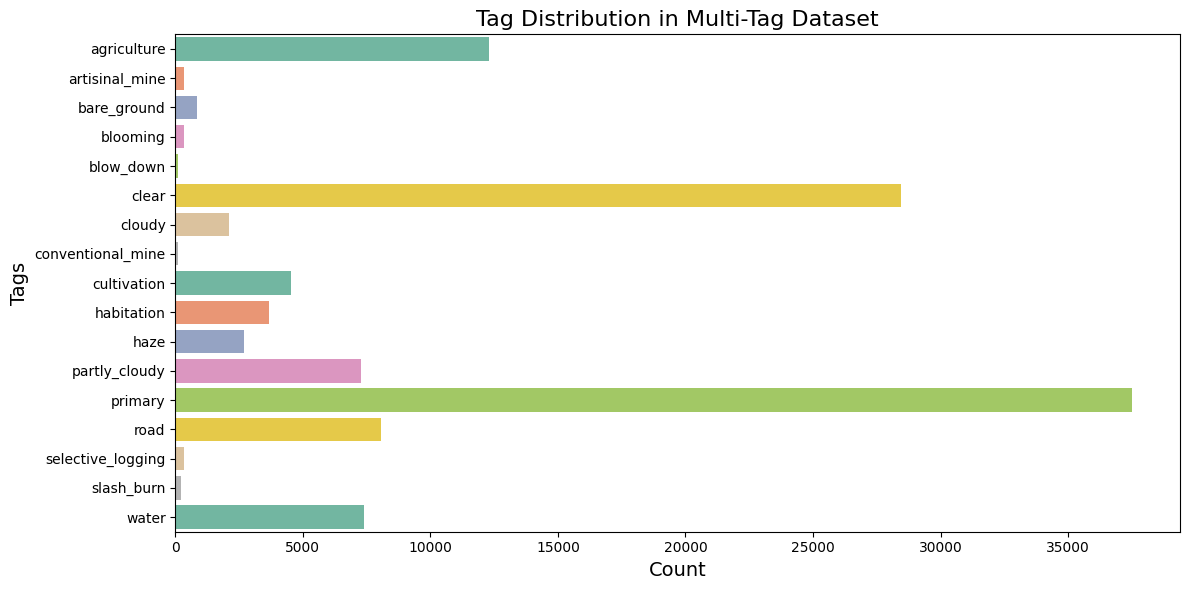

Standard Deviation of Tag Frequencies: 37670.58183190001
IRperLabel: {'bare_ground': 0.021294992465228885, 'conventional_mine': 0.002470416759307295, 'haze': 0.06662713999851776, 'artisinal_mine': 0.00837471281405173, 'cultivation': 0.11060055831418761, 'blooming': 0.00820178364090022, 'clear': 0.702364188838657, 'habitation': 0.090417253390647, 'slash_burn': 0.005163171026952247, 'primary': 0.9267274389189456, 'water': 0.18308258603226366, 'partly_cloudy': 0.1793769608933027, 'selective_logging': 0.008399416981644803, 'cloudy': 0.05160700610192939, 'agriculture': 0.3042318239086934, 'blow_down': 0.0024210084241211493, 'road': 0.1993873366436918}
MeanIR: 0.16886751736194366
CVIR: 1.5019480501275149


In [6]:
plot_spread(df)
get_std_dev(df)
IR = calculate_IRperLabel(all_tags, df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

# Import other dataframes

In [7]:
LP_undersampled_df = pd.read_csv("LP_undersampled_df.csv")
#LP_oversampled_df = pd.read_csv("LP_oversampled_df.csv") # Not in github due to large size, download from google drive
ML_undersampled_df = pd.read_csv("ML_undersampled_df.csv")
ML_oversampled_duplicate_df = pd.read_csv("ML_oversampled_duplicate_df.csv")
ML_oversampled_augment_df = pd.read_csv("ML_oversampled_augment_df.csv") # Must download zip file from google drive, and put into same directory as data
REMEDIAL_modified_df = pd.read_csv("REMEDIAL_modified_df.csv")

In [8]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

# Train

In [9]:
# Choose which dataframe to use
df_to_load = ML_oversampled_augment_df

In [10]:
# ResNet & DenseNet
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# EfficientNet_b1
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
dataset = MultiLabelImageDataset(df_to_load, img_dir="data/planet\planet/train-jpg", transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
# Since valiation split already done above with original data so no need

# # Only quick testing
#train_idx_small = train_idx[:1000]  # First 1000 training samples
#test_idx_small = test_idx[:200]  # First 200 testing samples

#train_idx_small = train_idx[:32787] 
#test_idx_small = test_idx[:3644] 

#train_dataset = Subset(dataset, train_idx_small)
#test_dataset = Subset(dataset, test_idx_small)
train_dataset = Subset(dataset, list(range(len(df_to_load))))
val_dataset = MultiLabelImageDataset(val, img_dir="data/planet\planet/train-jpg", transform=transform)
val_dataset = Subset(val_dataset, list(range(len(val))))

#train_dataset = Subset(dataset, train_idx)
#test_dataset = Subset(dataset, test_idx)

print(len(train_idx))
print(len(test_idx))



batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

65575
7287


In [12]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ResNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.resnet50(weights='DEFAULT')
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#model = ResNetClassifier(num_classes)
model = EfficientNetClassifier(num_classes)
model.to(device)
#model

Using cuda device


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def train_loop(dataloader, val_dataloader, model, loss_fn, threshold, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        #if batch % 640 == 0:
        #    val_loop(val_dataloader, model, loss_fn, threshold)

# Not used for modified dataframes
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss

def val_loop(dataloader, model, loss_fn, threshold):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > threshold #0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    val_loss /= num_batches
    f2 /= num_batches
    
    print(f"Val Error: \n f2 score: {f2:.5f}, avg loss: {val_loss:>8f} \n")
    return f2, val_loss


In [15]:
learning_rate = 1e-6 #0.00001
epochs = 5
threshold = 0.20

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, val_dataloader, model, loss_fn, threshold, optimizer)
    #f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    val_loop(val_dataloader, model, loss_fn)
    #all_loss.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.694673  [    8/72862]
Val Error: 
 f2 score: 0.50120, avg loss: 0.692700 

loss: 0.679708  [  520/72862]
loss: 0.664319  [ 1032/72862]
loss: 0.640999  [ 1544/72862]
loss: 0.621541  [ 2056/72862]
loss: 0.596756  [ 2568/72862]
loss: 0.554001  [ 3080/72862]
loss: 0.534228  [ 3592/72862]
loss: 0.480022  [ 4104/72862]
loss: 0.370847  [ 4616/72862]
loss: 0.335922  [ 5128/72862]
Val Error: 
 f2 score: 0.57603, avg loss: 0.373818 

loss: 0.369978  [ 5640/72862]
loss: 0.325722  [ 6152/72862]
loss: 0.161145  [ 6664/72862]
loss: 0.317989  [ 7176/72862]
loss: 0.304877  [ 7688/72862]
loss: 0.207481  [ 8200/72862]
loss: 0.137303  [ 8712/72862]
loss: 0.173042  [ 9224/72862]
loss: 0.192308  [ 9736/72862]
loss: 0.326924  [10248/72862]
Val Error: 
 f2 score: 0.73786, avg loss: 0.236332 

loss: 0.171686  [10760/72862]
loss: 0.204422  [11272/72862]
loss: 0.127796  [11784/72862]
loss: 0.199234  [12296/72862]
loss: 0.233697  [12808/72862]
loss: 0.205244  [1332

KeyboardInterrupt: 

# Export Models

In [ ]:
torch.save(model, "model.pth")